In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2024-08-09 12:52:45.770480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 12:52:45.778695: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-09 12:52:45.858053: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-09 12:52:45.934657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 12:52:45.991111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

This notebook follows the tutorial by Andrea Mari: https://pennylane.ai/qml/demos/tutorial_quanvolution/

In [8]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Load the MNIST dataset

In [5]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Initialise a default qubit device with 4 qubits. Prepare a quantum circuit consiting of an embedding layer, a random circuit (of n_layers), and a final measurement on each qubit.

In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Define the convolution scheme:

In [7]:
def quanv(image):
    """Devide the image into 2x2 sqaures and process each square by the quantum circuit. The 
    4 measured expectation values are mapped into 4 different channels of a single output pixel"""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Pre-process the dataset:

In [9]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


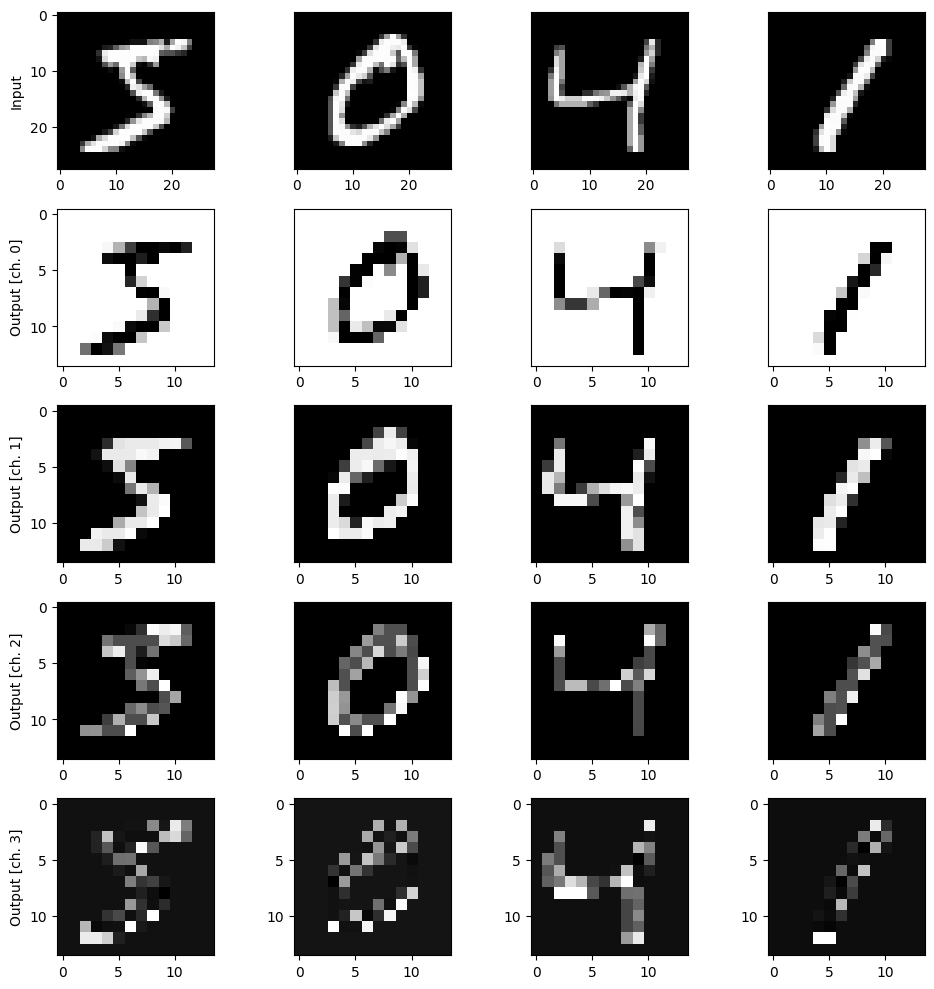

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

We have applied the quantum convolution layer. In order to train a classical neural network to classify the 10 different digits, we need to forward the resultung features to it.
We make use of a fully connected layer with 10 output nodes and the softmax activation function.

In [11]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

The next step is to perform the training.

In [12]:
#initialise
q_model = MyModel()
# train and validate
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 38ms/step - accuracy: 0.1200 - loss: 2.9220 - val_accuracy: 0.2000 - val_loss: 2.3198
Epoch 2/30
13/13 - 0s - 3ms/step - accuracy: 0.3600 - loss: 2.0136 - val_accuracy: 0.2000 - val_loss: 2.1324
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.5400 - loss: 1.7132 - val_accuracy: 0.4000 - val_loss: 1.9506
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.7000 - loss: 1.4108 - val_accuracy: 0.4667 - val_loss: 1.7913
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8200 - loss: 1.1708 - val_accuracy: 0.4667 - val_loss: 1.6803
Epoch 6/30
13/13 - 0s - 3ms/step - accuracy: 0.9000 - loss: 0.9848 - val_accuracy: 0.4667 - val_loss: 1.5870
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9200 - loss: 0.8304 - val_accuracy: 0.4667 - val_loss: 1.5015
Epoch 8/30
13/13 - 0s - 4ms/step - accuracy: 0.9400 - loss: 0.7078 - val_accuracy: 0.5333 - val_loss: 1.4317
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.6068 - val_accuracy: 0.5333 - val_loss: 1.3742
Epoch 10/30
13/13 

Also train without the quantum pre-processing to compare the results with and without the quantum convolution layer.

In [13]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - 28ms/step - accuracy: 0.1200 - loss: 2.3852 - val_accuracy: 0.2000 - val_loss: 2.1878
Epoch 2/30
13/13 - 0s - 3ms/step - accuracy: 0.3800 - loss: 1.9909 - val_accuracy: 0.3000 - val_loss: 2.0382
Epoch 3/30
13/13 - 0s - 3ms/step - accuracy: 0.5800 - loss: 1.7097 - val_accuracy: 0.4667 - val_loss: 1.9048
Epoch 4/30
13/13 - 0s - 3ms/step - accuracy: 0.7400 - loss: 1.4748 - val_accuracy: 0.5000 - val_loss: 1.7857
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8400 - loss: 1.2766 - val_accuracy: 0.5000 - val_loss: 1.6811
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.8400 - loss: 1.1099 - val_accuracy: 0.6333 - val_loss: 1.5910
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9000 - loss: 0.9702 - val_accuracy: 0.6667 - val_loss: 1.5144
Epoch 8/30
13/13 - 0s - 3ms/step - accuracy: 0.9400 - loss: 0.8533 - val_accuracy: 0.6667 - val_loss: 1.4497
Epoch 9/30
13/13 - 0s - 3ms/step - accuracy: 0.9600 - loss: 0.7550 - val_accuracy: 0.7333 - val_loss: 1.3946
Epoch 10/30
13/13 

Finally, we can visualise the results.

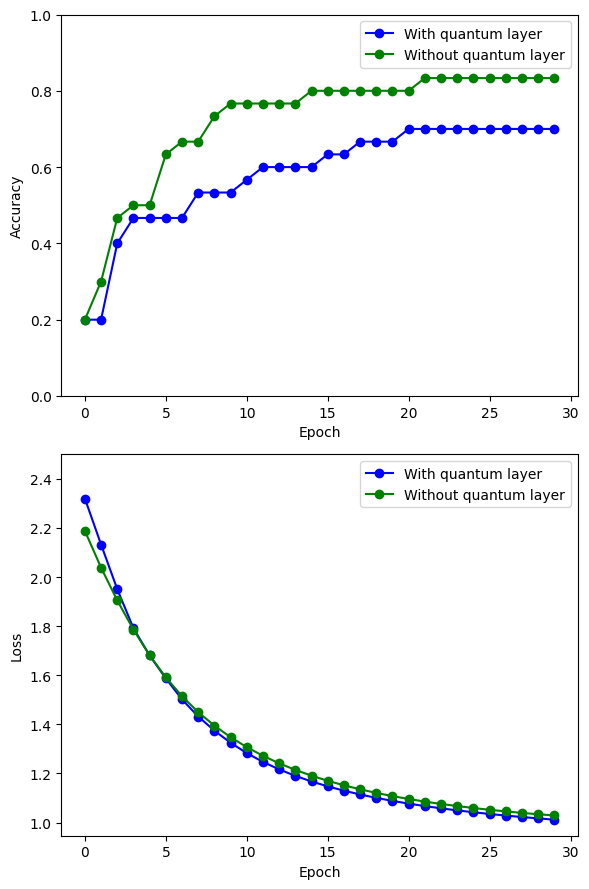

In [15]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

We notice that using the quantum pre-processing slightly lowers the accuracy.